In [1]:
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Softmax, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, LSTM, concatenate
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.metrics import Accuracy, Precision, Recall, SparseCategoricalAccuracy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2023-04-05 16:31:12.116404: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-05 16:31:12.852641: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-05 16:31:12.858539: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 16:31:16.529154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('../data/test/dynamic/bad/021.csv', nrows=150)
X = df[['flex_1', 'flex_2', 'flex_3', 'flex_4', 'flex_5', 'GYRx', 'GYRy', 'GYRz', 'ACCx', 'ACCy', 'ACCz']].values
labels = df.iloc[:, -1]
label_dict = {label: i for i, label in enumerate(sorted(set(labels)))}
y = np.array([label_dict[label] for label in labels])
y = to_categorical(y, num_classes=len(label_dict))

In [3]:
# Get the time interval between samples
dt = np.mean(np.diff(df.index))

# Calculate the velocity vectors
vx = np.cumsum(df['ACCx'] * dt)
vy = np.cumsum(df['ACCy'] * dt)
vz = np.cumsum(df['ACCz'] * dt)

# Calculate the displacement vectors
dx = np.cumsum(vx * dt)
dy = np.cumsum(vy * dt)
dz = np.cumsum(vz * dt)

# Combine the displacement vectors into a single array
displacement_vectors = np.column_stack((dx, dy, dz))

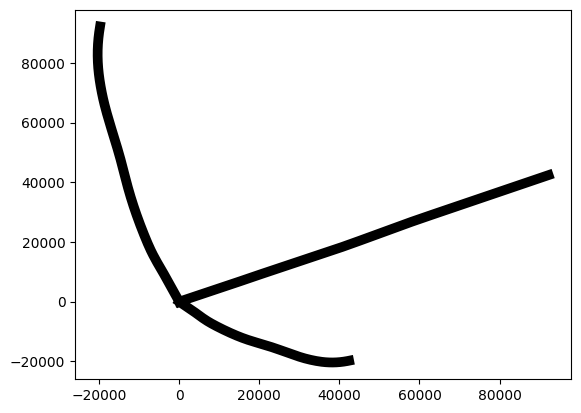

In [4]:
# Assuming you have a list of 3D displacement vectors called `displacement_vectors`
xy_projection = [(d[0], d[1]) for d in displacement_vectors]
yz_projection = [(d[1], d[2]) for d in displacement_vectors]
zx_projection = [(d[2], d[0]) for d in displacement_vectors]

# Plot the projections
plt.plot(*zip(*xy_projection), linewidth=7, color='black')
plt.savefig('xy_projection.png')
plt.plot(*zip(*yz_projection), linewidth=7, color='black')
plt.savefig('yz_projection.png')
plt.plot(*zip(*zx_projection), linewidth=7, color='black')
plt.savefig('zx_projection.png')

In [5]:
image = plt.imread('xy_projection.png')
normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

In [6]:
print(X.shape)
print(y.shape)

(150, 11)
(150, 1)


In [7]:
# model = Sequential()
# model.add(Conv1D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
# model.add(MaxPooling1D((2, 2)))
# model.add(Conv1D(64, (3, 3), activation='relu'))
# model.add(MaxPooling1D((2, 2)))
# model.add(Conv1D(128, (3, 3), activation='relu'))
# model.add(MaxPooling1D((2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(40, activation='softmax'))

flex1 = Input(shape=(150, 1), name='flex1')
flex2 = Input(shape=(150, 1), name='flex2')
flex3 = Input(shape=(150, 1), name='flex3')
flex4 = Input(shape=(150, 1), name='flex4')
flex5 = Input(shape=(150, 1), name='flex5')
accx = Input(shape=(150, 1), name='accx')
accy = Input(shape=(150, 1), name='accy')
accz = Input(shape=(150, 1), name='accz')
gyrx = Input(shape=(150, 1), name='gyrx')
gyry = Input(shape=(150, 1), name='gyry')
gyrz = Input(shape=(150, 1), name='gyrz')

conv1_flex1 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu', name='conv1_flex1')(flex1)
conv1_flex2 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu', name='conv1_flex2')(flex2)
conv1_flex3 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu', name='conv1_flex3')(flex3)
conv1_flex4 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu', name='conv1_flex4')(flex4)
conv1_flex5 = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu', name='conv1_flex5')(flex5)
conv1_accx = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu', name='conv1_accx')(accx)
conv1_accy = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu', name='conv1_accy')(accy)
conv1_accz = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu', name='conv1_accz')(accz)
conv1_gyrx = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu', name='conv1_gyrx')(gyrx)
conv1_gyry = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu', name='conv1_gyry')(gyry)
conv1_gyrz = Conv1D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu', name='conv1_gyrz')(gyrz)

conv2_flex1 = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv2_flex1')(conv1_flex1)
conv2_flex2 = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv2_flex2')(conv1_flex2)
conv2_flex3 = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv2_flex3')(conv1_flex3)
conv2_flex4 = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv2_flex4')(conv1_flex4)
conv2_flex5 = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv2_flex5')(conv1_flex5)
conv2_accx = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv2_accx')(conv1_accx)
conv2_accy = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv2_accy')(conv1_accy)
conv2_accz = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv2_accz')(conv1_accz)
conv2_gyrx = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv2_gyrx')(conv1_gyrx)
conv2_gyry = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv2_gyry')(conv1_gyry)
conv2_gyrz = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv2_gyrz')(conv1_gyrz)

batch1_flex1 = BatchNormalization(name='batch1_flex1')(conv2_flex1)
batch1_flex2 = BatchNormalization(name='batch1_flex2')(conv2_flex2)
batch1_flex3 = BatchNormalization(name='batch1_flex3')(conv2_flex3)
batch1_flex4 = BatchNormalization(name='batch1_flex4')(conv2_flex4)
batch1_flex5 = BatchNormalization(name='batch1_flex5')(conv2_flex5)
batch1_accx = BatchNormalization(name='batch1_accx')(conv2_accx)
batch1_accy = BatchNormalization(name='batch1_accy')(conv2_accy)
batch1_accz = BatchNormalization(name='batch1_accz')(conv2_accz)
batch1_gyrx = BatchNormalization(name='batch1_gyrx')(conv2_gyrx)
batch1_gyry = BatchNormalization(name='batch1_gyry')(conv2_gyry)
batch1_gyrz = BatchNormalization(name='batch1_gyrz')(conv2_gyrz)

maxpool1_flex1 = MaxPooling1D(pool_size=2, name='maxpool1_flex1')(batch1_flex1)
maxpool1_flex2 = MaxPooling1D(pool_size=2, name='maxpool1_flex2')(batch1_flex2)
maxpool1_flex3 = MaxPooling1D(pool_size=2, name='maxpool1_flex3')(batch1_flex3)
maxpool1_flex4 = MaxPooling1D(pool_size=2, name='maxpool1_flex4')(batch1_flex4)
maxpool1_flex5 = MaxPooling1D(pool_size=2, name='maxpool1_flex5')(batch1_flex5)
maxpool1_accx = MaxPooling1D(pool_size=2, name='maxpool1_accx')(batch1_accx)
maxpool1_accy = MaxPooling1D(pool_size=2, name='maxpool1_accy')(batch1_accy)
maxpool1_accz = MaxPooling1D(pool_size=2, name='maxpool1_accz')(batch1_accz)
maxpool1_gyrx = MaxPooling1D(pool_size=2, name='maxpool1_gyrx')(batch1_gyrx)
maxpool1_gyry = MaxPooling1D(pool_size=2, name='maxpool1_gyry')(batch1_gyry)
maxpool1_gyrz = MaxPooling1D(pool_size=2, name='maxpool1_gyrz')(batch1_gyrz)

conv3_flex1 = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv3_flex1')(maxpool1_flex1)
conv3_flex2 = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv3_flex2')(maxpool1_flex2)
conv3_flex3 = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv3_flex3')(maxpool1_flex3)
conv3_flex4 = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv3_flex4')(maxpool1_flex4)
conv3_flex5 = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv3_flex5')(maxpool1_flex5)
conv3_accx = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv3_accx')(maxpool1_accx)
conv3_accy = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv3_accy')(maxpool1_accy)
conv3_accz = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv3_accz')(maxpool1_accz)
conv3_gyrx = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv3_gyrx')(maxpool1_gyrx)
conv3_gyry = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv3_gyry')(maxpool1_gyry)
conv3_gyrz = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv3_gyrz')(maxpool1_gyrz)

conv4_flex1 = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv4_flex1')(conv3_flex1)
conv4_flex2 = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv4_flex2')(conv3_flex2)
conv4_flex3 = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv4_flex3')(conv3_flex3)
conv4_flex4 = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv4_flex4')(conv3_flex4)
conv4_flex5 = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv4_flex5')(conv3_flex5)
conv4_accx = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv4_accx')(conv3_accx)
conv4_accy = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv4_accy')(conv3_accy)
conv4_accz = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv4_accz')(conv3_accz)
conv4_gyrx = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv4_gyrx')(conv3_gyrx)
conv4_gyry = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv4_gyry')(conv3_gyry)
conv4_gyrz = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='conv4_gyrz')(conv3_gyrz)

batch2_flex1 = BatchNormalization(name='batch2_flex1')(conv4_flex1)
batch2_flex2 = BatchNormalization(name='batch2_flex2')(conv4_flex2)
batch2_flex3 = BatchNormalization(name='batch2_flex3')(conv4_flex3)
batch2_flex4 = BatchNormalization(name='batch2_flex4')(conv4_flex4)
batch2_flex5 = BatchNormalization(name='batch2_flex5')(conv4_flex5)
batch2_accx = BatchNormalization(name='batch2_accx')(conv4_accx)
batch2_accy = BatchNormalization(name='batch2_accy')(conv4_accy)
batch2_accz = BatchNormalization(name='batch2_accz')(conv4_accz)
batch2_gyrx = BatchNormalization(name='batch2_gyrx')(conv4_gyrx)
batch2_gyry = BatchNormalization(name='batch2_gyry')(conv4_gyry)
batch2_gyrz = BatchNormalization(name='batch2_gyrz')(conv4_gyrz)

maxpool2_flex1 = MaxPooling1D(pool_size=2, name='maxpool2_flex1')(batch2_flex1)
maxpool2_flex2 = MaxPooling1D(pool_size=2, name='maxpool2_flex2')(batch2_flex2)
maxpool2_flex3 = MaxPooling1D(pool_size=2, name='maxpool2_flex3')(batch2_flex3)
maxpool2_flex4 = MaxPooling1D(pool_size=2, name='maxpool2_flex4')(batch2_flex4)
maxpool2_flex5 = MaxPooling1D(pool_size=2, name='maxpool2_flex5')(batch2_flex5)
maxpool2_accx = MaxPooling1D(pool_size=2, name='maxpool2_accx')(batch2_accx)
maxpool2_accy = MaxPooling1D(pool_size=2, name='maxpool2_accy')(batch2_accy)
maxpool2_accz = MaxPooling1D(pool_size=2, name='maxpool2_accz')(batch2_accz)
maxpool2_gyrx = MaxPooling1D(pool_size=2, name='maxpool2_gyrx')(batch2_gyrx)
maxpool2_gyry = MaxPooling1D(pool_size=2, name='maxpool2_gyry')(batch2_gyry)
maxpool2_gyrz = MaxPooling1D(pool_size=2, name='maxpool2_gyrz')(batch2_gyrz)

# merged = concatenate([maxpool2_flex1, maxpool2_flex2, maxpool2_flex3, maxpool2_flex4, maxpool2_flex5])
merged = concatenate([maxpool2_flex1, maxpool2_flex2, maxpool2_flex3, maxpool2_flex4, maxpool2_flex5, maxpool2_accx, maxpool2_accy, maxpool2_accz, maxpool2_gyrx, maxpool2_gyry])
# merged = concatenate([maxpool2_flex1, maxpool2_flex2, maxpool2_flex3, maxpool2_flex4, maxpool2_flex5, maxpool2_accx, maxpool2_accy, maxpool2_accz, maxpool2_gyrx, maxpool2_gyry, maxpool2_gyrz])
dense = Dense(544)(merged)
# dense = Dense(544)(maxpool2_flex1)
output = Dense(50, activation='softmax')(dense)

# model = Model(inputs=[flex1, flex2, flex3, flex4, flex5], outputs=output)
model = Model(inputs=[flex1, flex2, flex3, flex4, flex5, accx, accy, accz, gyrx, gyry, gyrz], outputs=output)
# model = Model(inputs=flex1, outputs=output)

# model.compile(optimizer=Adam, loss=categorical_crossentropy, metrics=['accuracy'])
model.compile(optimizer='adam', loss=categorical_crossentropy, metrics=[Accuracy(), Precision(), Recall(), SparseCategoricalAccuracy()])
model.save('../models/test.h5')

In [8]:
model.fit([X[:, i] for i in range(10)], y, epochs=10)

Epoch 1/10


ValueError: in user code:

    File "/home/fathi/dev/thesis/code/venv/lib64/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/fathi/dev/thesis/code/venv/lib64/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/fathi/dev/thesis/code/venv/lib64/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/fathi/dev/thesis/code/venv/lib64/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/fathi/dev/thesis/code/venv/lib64/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/fathi/dev/thesis/code/venv/lib64/python3.11/site-packages/keras/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 11 input(s), but it received 10 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(None,) dtype=float32>, <tf.Tensor 'IteratorGetNext:5' shape=(None,) dtype=float32>, <tf.Tensor 'IteratorGetNext:6' shape=(None,) dtype=float32>, <tf.Tensor 'IteratorGetNext:7' shape=(None,) dtype=float32>, <tf.Tensor 'IteratorGetNext:8' shape=(None,) dtype=float32>, <tf.Tensor 'IteratorGetNext:9' shape=(None,) dtype=float32>]
